# Sankey diagram

In [ ]:
import numpy as np,pandas as pd
from matplotlib import pyplot as plt

import plotly.graph_objects as go
import plotly.io as pio

import scipy.stats as stats

Data is a csv/excel file, with H1-H3 columns as control and H4-H6 as experimental file, the value represent RNA level (not know if it is log2 transformed already, but use Avg2/Avg1 for FC)

## Calculate p-value

In [ ]:
df = pd.read_csv('hong_data.csv',na_values=['#N/A'])
df['Gene'] = df['human_gene']

# Remove zero as it affect p value
df[['H1', 'H2', 'H3', 'H4', 'H5', 'H6']] = df[['H1', 'H2', 'H3', 'H4', 'H5', 'H6']].replace(0, np.nan)

df['Control'] = df[['H1','H2','H3']].mean(1)
df['Experiment'] = df[['H4','H5','H6']].mean(1)

# Calculate fold change and log fold change
df['Fold Change'] = df['Experiment'] / df['Control']
df['Log2 Fold Change'] = np.log2(df['Fold Change'])

# Perform t-test between Control and Experiment groups
control_cols = ['H1', 'H2', 'H3']
experiment_cols = ['H4', 'H5', 'H6']


In [ ]:
def ttest_row(row):
    # Extract values from each group and drop NaN values
    group1 = row[['H1', 'H2', 'H3']].dropna().astype(float)  # Group 1: Drop NaN and convert to float
    group2 = row[['H4', 'H5', 'H6']].dropna().astype(float)  # Group 2: Drop NaN and convert to float

    # Perform t-test only if both groups have at least 2 values
    if len(group1) > 1 and len(group2) > 1:
        t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=False)  # Welch's t-test (unequal variance),which is more robust when the two groups may not have the same variance.
        return pd.Series({'T-statistic': t_stat, 'P-value': p_value})
    else:
        return pd.Series({'T-statistic': np.nan, 'P-value': np.nan})

# Apply the function row-wise
result = df.apply(ttest_row, axis=1)

In [ ]:
df = pd.concat([df,result],axis=1)

In [ ]:
# Compute the -log10 of the 'P-value'
df['log10_P'] = -np.log10(df['P-value'])

# Assign the sign of 'Log2 Fold Change' to the 'log10_P' values
df['signed_log10_P'] = np.sign(df['Log2 Fold Change']) * df['log10_P']

In [ ]:
df.to_csv('ttest_processed_zero_exclude.csv',index=False)

## Pathway analysis

Get up-regulated genes and down-regulated genes with p-value<0.05; do analysis separately.

Go to [DAVID bioinformatics website](https://david.ncifcrf.gov/tools.jsp), go to Upload --> Step 1: paste gene symbols --> Step2: Official Gene Symbol, select species, if mouse: mus, if human: homo,  --> Step3: select Gene List --> Step4: submit.

Click `start analysis`, go to GO-BP, click chart, download gene list.

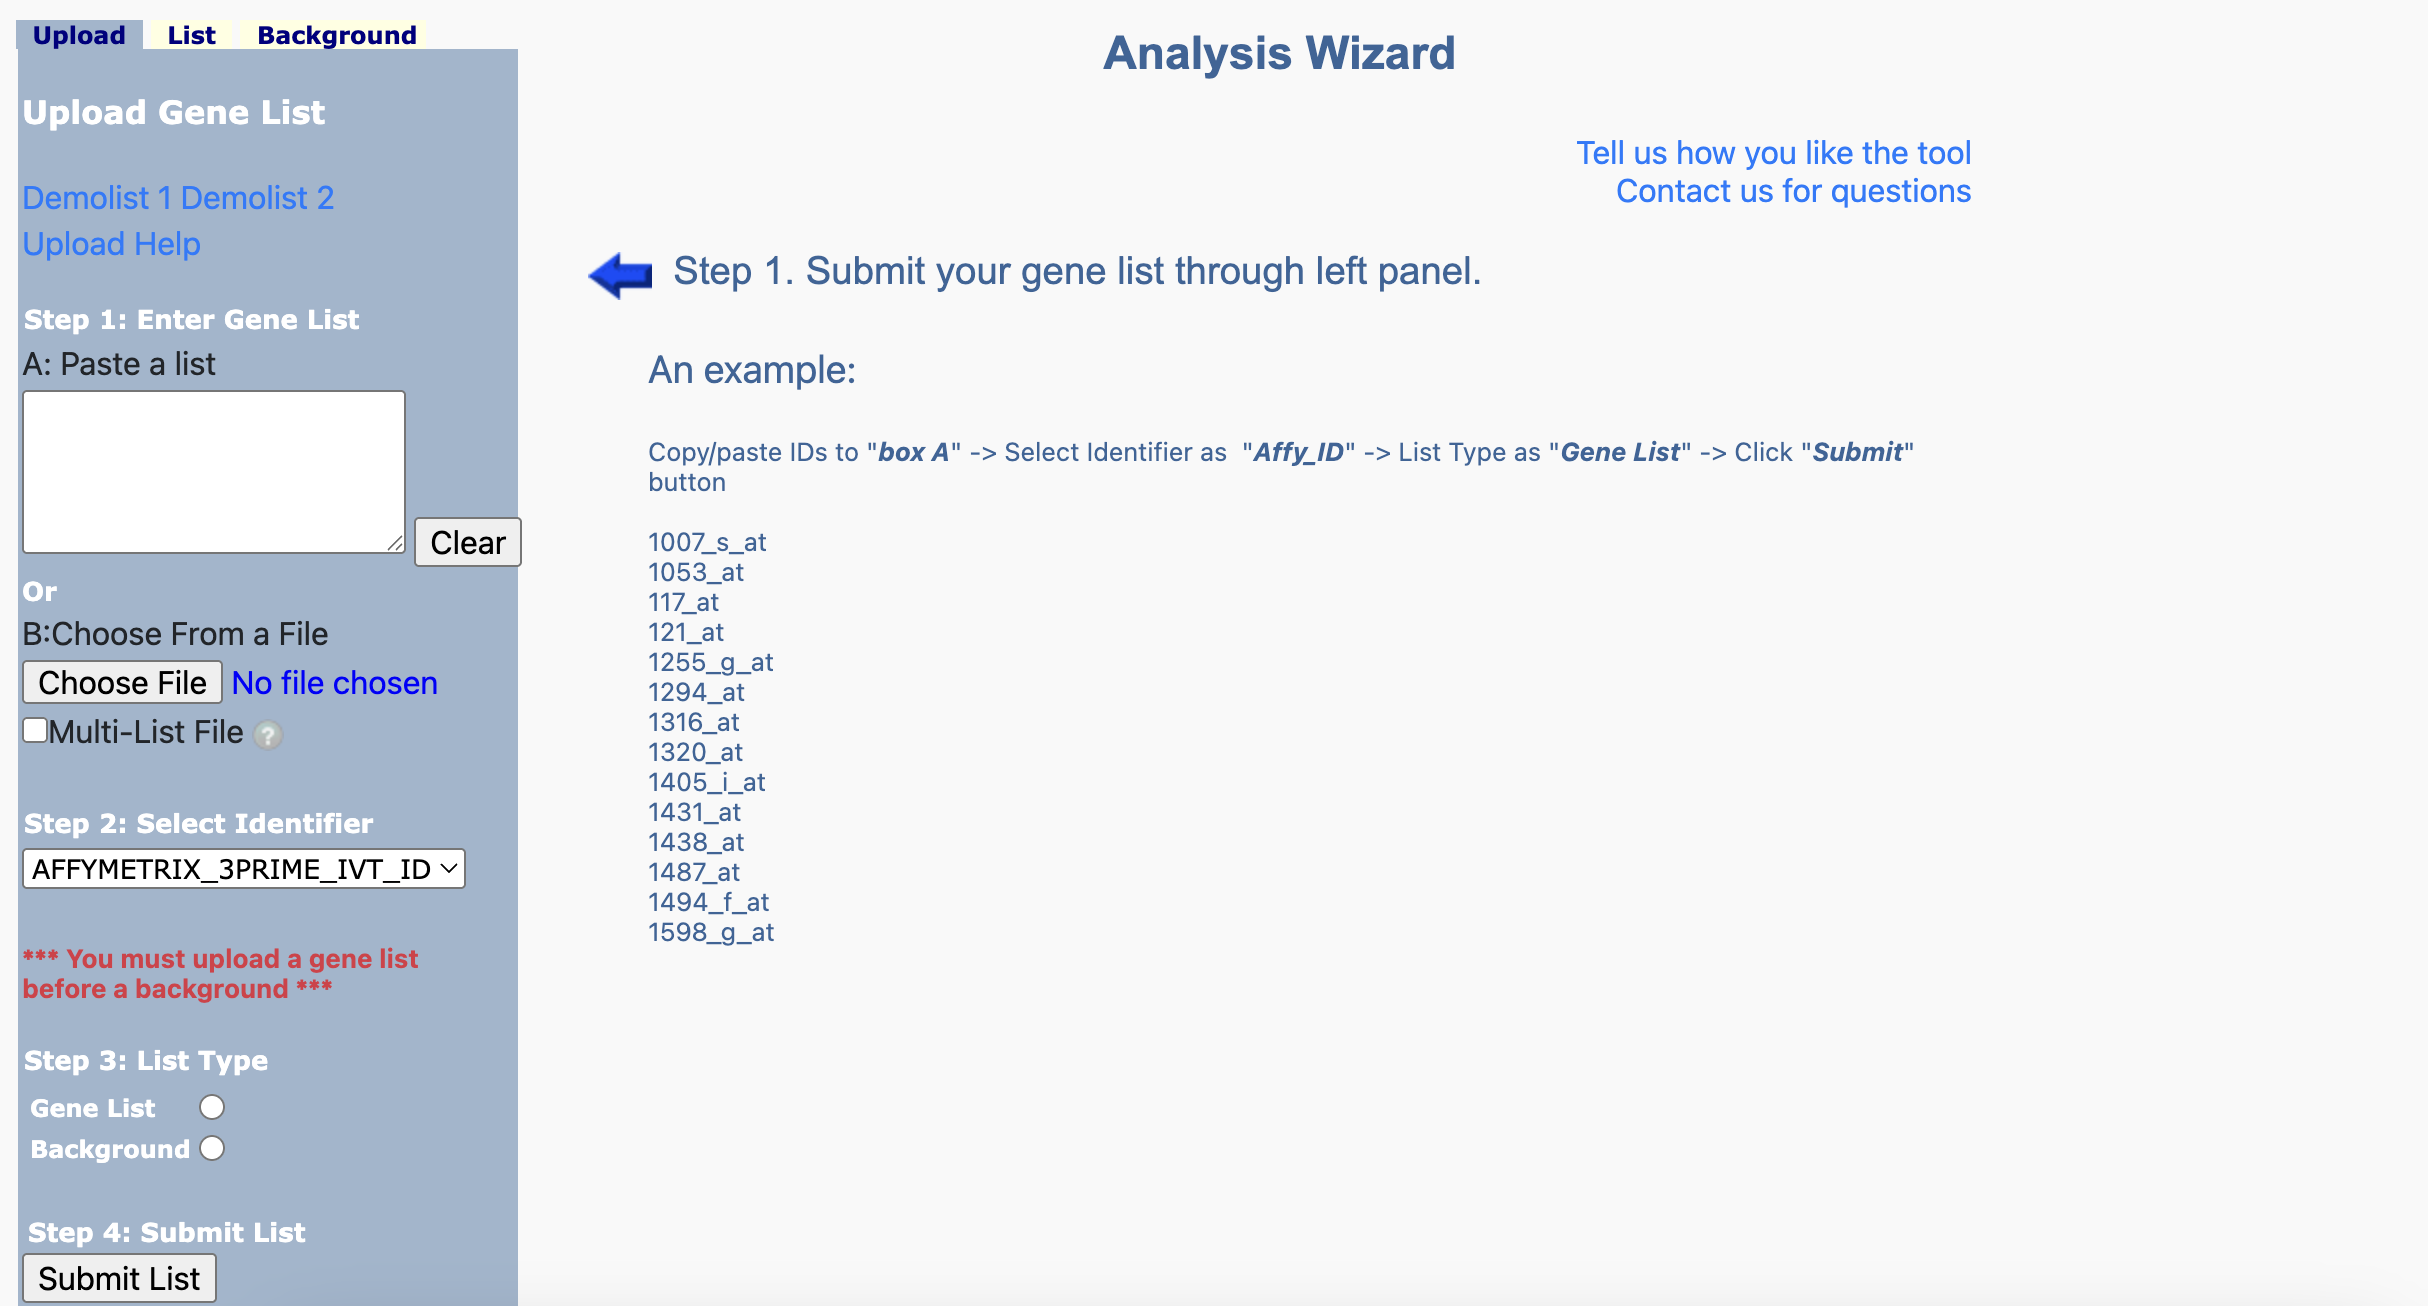

## (Optional) Plot gene expression

In [ ]:
df_cleaned = df.dropna(subset=['Fold Change'])  # Drop NaN values
df_cleaned = df_cleaned[df_cleaned['Fold Change'] != 0]  # Drop 0 values
df_cleaned = df_cleaned[np.isfinite(df_cleaned['Fold Change'])]  # Drop inf and -inf values

In [ ]:
df_cleaned['zero'] = 0

In [ ]:
df_cleaned = df_cleaned.sort_values('signed_log10_P',ascending=False).reset_index(drop=True)

In [ ]:
df_sig = df_cleaned.query('`P-value` <=0.05').copy()

In [ ]:
plot_sankey(pd.concat([df_sig.head(100),df_sig.tail(100)]),'human_gene','zero','signed_log10_P')

## Sankey for pathway analysis

In [ ]:
def plot_sankey(df, gene_col, col1, col2,figsize=(1000,600),write=False,link_colors=None,link_values=None):
  df = df.copy()

  # Combine control and experiment values into a single array for joint normalization
  all_values = pd.concat([df[col1], df[col2]])

  # Normalize all values together
  normalized_values = (all_values - all_values.min()) / (all_values.max() - all_values.min())

  normalized_values = (1-normalized_values)+1e-13

  # Split back into control and experiment
  df[f'{col1}_norm'] = normalized_values[:len(df)]
  df[f'{col2}_norm'] = normalized_values[len(df):]

  # Define the source (control) and target (experiment) nodes
  sources = list(range(len(df)))  # Control nodes (one per gene)
  targets = list(range(len(df), 2 * len(df)))  # Experiment nodes (one per gene)

  customdata = [[0, orig_y, inv_y] for orig_y, inv_y in zip(df[col1], df[f'{col1}_norm'])] + \
              [[0.5, orig_y, inv_y] for orig_y, inv_y in zip(df[col2], df[f'{col2}_norm'])]

  # Create the Sankey diagram with y-axis positions reflecting joint-normalized values and uniform height
  fig = go.Figure(go.Sankey(
      arrangement = "perpendicular",
      node=dict(
          pad=15,
          thickness=10,  # Uniform thickness for all nodes
          line=dict(color="black", width=0.5),
          label=['']*len(df) + df[gene_col].tolist(),  # Labels for control and experiment nodes
          color=["blue"] * len(df)*2 if not link_colors else link_colors*2,  # Blue for control, green for experiment
          x=[0.01] * len(df) + [0.99] * len(df),  # Left (x=0) for control, right (x=1) for experiment
          y=df[f'{col1}_norm'].tolist() + df[f'{col2}_norm'].tolist(),  # Y positions based on joint-normalized values
          customdata=customdata,
          hovertemplate='Gene: %{label}<br>Value: %{customdata[1]:.2f}'

      ),
      link=dict(
          source=sources,  # Link control nodes to experiment nodes
          target=targets,
          value=[0.01]*(len(df)) if not link_values else link_values,  # the expression is relative, changing 1 to 0.1 to all would not change as no variation
          color="rgba(0, 150, 255, 0.5)" if not link_colors else link_colors # Color of the links
      )
  ))

  # Update layout with titles
  fig.update_layout(
      title_text="Gene Expression Changes",
      font_size=10,
      autosize=False,
      width=figsize[0],
      height=figsize[1],
      margin=dict(r=300)
  )

  # Save the figure as an HTML file
  if write:
    pio.write_html(fig, file="sankey_diagram.html", auto_open=False)
  # Show the figure
  fig.show()

From the DAVID output csv, pick out important pathways.

In [ ]:
df = pd.read_csv('hong_highlight.csv')
df['term'] = df['Term'].str.split('~').str[-1]
df['term'] = df['term'].apply(lambda x: x[0].upper() + x[1:] if len(x) > 0 else x)

df['y_left'] = df.direction.map({'up':0.01,'down':0.99})
df['y_right'] = df.direction.map({'up':0.99,'down':0.01})

# fourth value is transparency
df['rgba_colors'] = df.direction.map({'up':"rgba(255, 99, 71, 0.5)",'down':"rgba(38, 101, 255, 0.5)"})

plot_sankey(df,'term',col1='y_left',col2='y_right',figsize=(1000,500),
            link_colors=df.rgba_colors.tolist(),
            link_values=df.signed_log10P.abs().tolist(),
            write=True
            )

## Bar plot

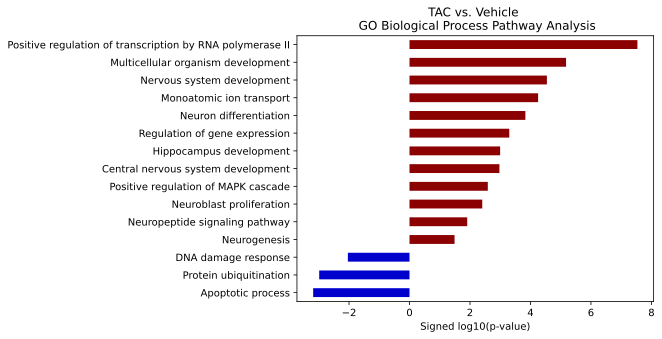

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the output format to SVG
%config InlineBackend.figure_format = 'svg'

df = pd.read_csv('hong_highlight.csv')
df['term'] = df['Term'].str.split('~').str[-1]
df['term'] = df['term'].apply(lambda x: x[0].upper() + x[1:] if len(x) > 0 else x)

data = df.set_index('term')['signed_log10P'].sort_values()
colors = data.apply(lambda x: 'darkred' if x > 0 else 'mediumblue')

data.plot.barh(color=colors)
plt.ylabel('')
plt.xlabel('Signed log10(p-value)')
plt.title('TAC vs. Vehicle \n GO Biological Process Pathway Analysis')
plt.savefig('barplot.svg',bbox_inches='tight')

## Others

In [ ]:
def plot_sankey_multicol(df, columns):
    df = df.copy()
    num_col = len(columns)
    all_values = pd.concat([df[col] for col in columns])

    # Normalize all values together
    normalized_values = (all_values - all_values.min()) / (all_values.max() - all_values.min())

    # invert the value as html use 0 as highest value
    normalized_values = 1-normalized_values

    # plotly can't deal with 0 value, so add a small number to 0
    normalized_values = [i+1e-13 if i ==0 else i for i in normalized_values]

    # Assign normalized values back to DataFrame in new columns
    for i, col in enumerate(columns):
        df[col + '_norm'] = normalized_values[i*len(df):(i+1)*len(df)]

    # Prepare data for Sankey diagram
    nodes = []
    node_colors = []
    node_x = []
    node_y = []

    # Define colors for different conditions
    colors = ['blue', 'green', 'red', 'purple', 'orange', 'yellow']  # Extend colors as needed
    position_x = [i/(num_col-1) for i in range(num_col)]  # Positions along x-axis
    # as it can't deal with 0 effectively, add a small number
    position_x =[i+1e-13 if i ==0 else i for i in position_x]

    # Create nodes for each condition
    for i, col in enumerate(columns):
        nodes.extend(df['Gene'].tolist())
        node_colors.extend([colors[i % len(colors)]] * len(df))

        node_x.extend([position_x[i]] * len(df))
        node_y.extend(df[col + '_norm'].tolist())

    # Define source and target indices for links
    source = []
    target = []
    for i in range(num_col - 1):

        source.extend(range(i*len(df), (i+1)*len(df)))
        target.extend(range((i+1)*len(df), (i+2)*len(df)))

    # Define link properties
    link_value = [0.1] * (len(source)-1)+[0.1+0.000001]  # All links have a uniform flow size (can be adjusted)
    link_color = 'rgba(0, 150, 255, 0.5)'  # Link color

    # Create the Sankey diagram
    fig = go.Figure(go.Sankey(
        arrangement="fixed",
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=nodes,
            color=node_colors,
            x=node_x,
            y=node_y
        ),
        link=dict(
            source=source,
            target=target,
            value=link_value,
            color=link_color
        )
    ))

    # Update layout with titles
    fig.update_layout(
        title_text="Gene Expression Changes: Control vs Experiment",
        font_size=10,
        autosize=False,
        width=1000,
        height=600
    )

    # Show the figure
    fig.show()

# Example usage
df = pd.DataFrame({
    'Gene': ['Gene1', 'Gene2', 'Gene3', 'Gene4', 'Gene5', 'Gene6', 'Gene7', 'Gene8', 'Gene9', 'Gene10'],
    'Control': [1.0]*10,
    'Experiment1': [2.0]*10,
    'Experiment2': [3]*9+[1]*1
})
plot_sankey_multicol(df, ['Control', 'Experiment1', 'Experiment2'])